## Using a toy dataset to better understand SHapley Additive exPlanations (SHAP)
Using a simple DecisionTreeRegressor and a Catboost Regressor

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from jmspack.frequentist_statistics import correlation_analysis
from jmspack.utils import flatten, JmsColors

from sklearn.tree import DecisionTreeRegressor, plot_tree
from catboost import CatBoostRegressor, Pool
import shap

/opt/miniconda3/envs/ds_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
shap.initjs()

In [3]:
if "jms_style_sheet" in plt.style.available:
    plt.style.use("jms_style_sheet")

In [4]:
#### A data frame with 28 rows and 23 variables:

# - V1. Arbitrary item, answer format numeric, ranging from 0 to 3.
# - V1_1. Arbitrary item, answer format numeric, ranging from 0 to 1.
# - V1_2. Arbitrary item, answer format text.
# - V2. Arbitrary item, answer format numeric, ranging from 0 to 100.
# - V2_1. Arbitrary item, answer format numeric, ranging from 0 to 100.
# - V3. Arbitrary item, answer format numeric, ranging from 0 to 100.
# - V3_1. Arbitrary item, answer format text.
# - V4. Arbitrary item, answer format numeric, ranging from 0 to 1.
# - V4_1. Arbitrary item, answer format numeric, ranging from 0 to 4.
# - V5. Arbitrary item, answer format numeric, ranging from 0 to 6.
# - V5_1. Arbitrary item, answer format numeric, ranging from 0 to 6.
# - V5_2. Arbitrary item, answer format numeric, ranging from 0 to 6.
# - V7. Arbitrary item, answer format numeric, ranging from 0 to 1.
# - V8. Arbitrary item, answer format text.
# - V8_1. Arbitrary item, answer format numeric, ranging from 0 to 1.
# - V8_2. Arbitrary item, answer format numeric, ranging from 0 to 100.
# - V8_3. Arbitrary item, answer format numeric, ranging from 1 to 4.
# - survey_name. Name of the ESM version.
# - IMEI. IMEI number of the mobile device, used by the participant.
# - start_date. Date of when a single ESM questionnaire was started.
# - start_time. Time of when a single ESM questionnaire was started.
# - end_date. Date of when a single ESM questionnaire was ended.
# - end_time. Time of when a single ESM questionnaire was ended.

# df = (pd.read_csv("https://raw.githubusercontent.com/jameshtwose/Data-Science/master/Machine_learning/data/example_ESM.csv", 
#                   sep=";",
#                  index_col=0)
#       .dropna(axis=1, thresh=25)
#       .drop("IMEI", axis=1)
#       )

In [5]:
df = (pd.read_csv("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv")
      .dropna()
      .sample(frac=0.1, random_state=42)
      )

In [6]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
30,Adelie,Dream,39.5,16.7,178.0,3250.0,FEMALE
317,Gentoo,Biscoe,46.9,14.6,222.0,4875.0,FEMALE
79,Adelie,Torgersen,42.1,19.1,195.0,4000.0,MALE
201,Chinstrap,Dream,49.8,17.3,198.0,3675.0,FEMALE
63,Adelie,Biscoe,41.1,18.2,192.0,4050.0,MALE


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 30 to 69
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            33 non-null     object 
 1   island             33 non-null     object 
 2   bill_length_mm     33 non-null     float64
 3   bill_depth_mm      33 non-null     float64
 4   flipper_length_mm  33 non-null     float64
 5   body_mass_g        33 non-null     float64
 6   sex                33 non-null     object 
dtypes: float64(4), object(3)
memory usage: 2.1+ KB


In [8]:
cors_df = correlation_analysis(data=df, check_norm=True)["summary"]

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [9]:
cors_df[cors_df["p-value"] < 0.01].sort_values(by="r-value")

,analysis,feature1,feature2,r-value,p-value,stat-sign,N
3,Pearson,bill_depth_mm,flipper_length_mm,-0.538146,1.236426e-03,True,33
1,Pearson,bill_length_mm,flipper_length_mm,0.457633,7.410332e-03,True,33
5,Pearson,flipper_length_mm,body_mass_g,0.902848,6.768129e-13,True,33


In [10]:
feature_list = df.select_dtypes("float").columns.tolist()
outcome = "species"
len(feature_list), outcome

(4, 'species')

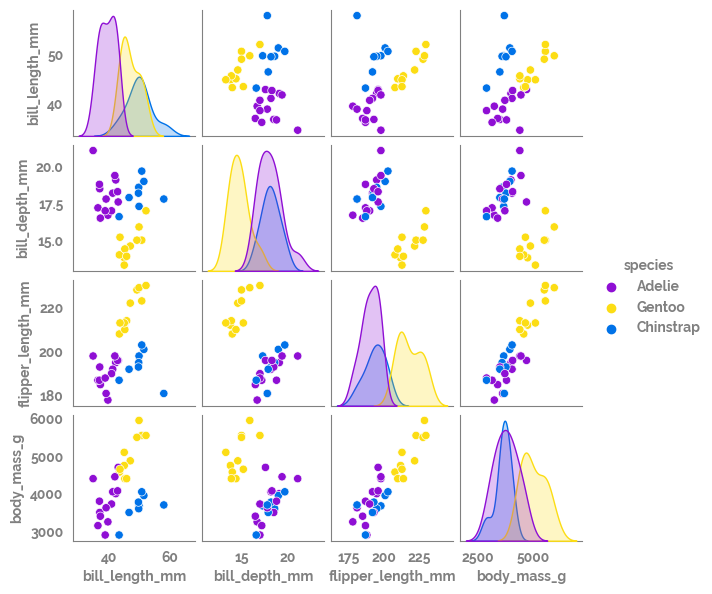

In [11]:
_ = sns.pairplot(data=df, hue="species", height=1.5)

In [12]:
df = df.assign(**{f"{outcome}_int": lambda d: d[outcome].astype("category").cat.codes})

In [13]:
train_idx = df.sample(frac=0.8, random_state=42).index.tolist()
test_idx = df.drop(train_idx, axis=0).index.tolist()

In [14]:
X_train = df.loc[train_idx, feature_list]
y_train = df.loc[train_idx, f"{outcome}_int"]

X_test = df.loc[test_idx, feature_list]
y_test = df.loc[test_idx, f"{outcome}_int"]

In [15]:
tree_model = DecisionTreeRegressor(criterion="absolute_error", max_depth=2, min_samples_leaf=1, min_samples_split=2, random_state = 100)
tree_model.fit(X=X_train, y=y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=2, random_state=100)

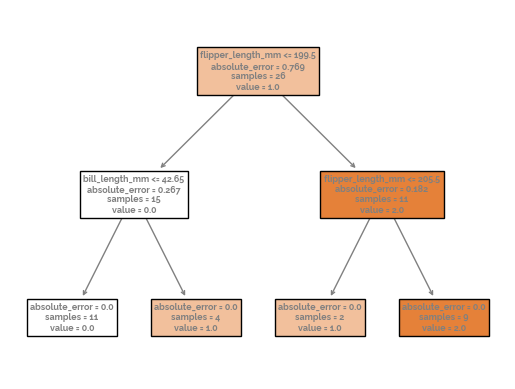

In [16]:
_ = plot_tree(tree_model, filled=True, feature_names=feature_list, label="all")

In [17]:
explainer = shap.TreeExplainer(tree_model)
shap_values = explainer.shap_values(X_test)
shap_values

array([[ 0.21153846,  0.        ,  0.86538462,  0.        ],
       [ 0.57820513,  0.        , -0.50128205,  0.        ],
       [ 0.57820513,  0.        , -0.50128205,  0.        ],
       [ 0.21153846,  0.        ,  0.86538462,  0.        ],
       [ 0.57820513,  0.        , -0.50128205,  0.        ],
       [ 0.57820513,  0.        , -0.50128205,  0.        ],
       [-0.21025641,  0.        , -0.71282051,  0.        ]])

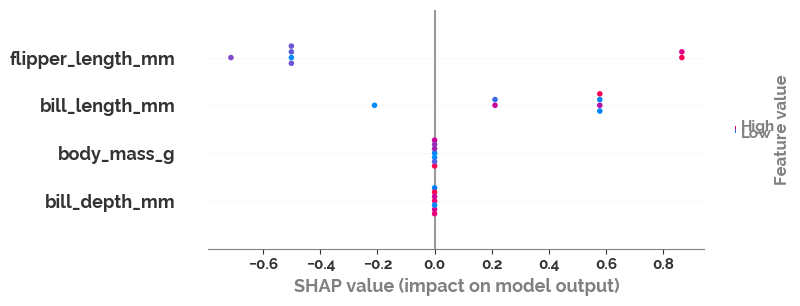

In [18]:
shap.summary_plot(shap_values, X_test)

In [19]:
shap_actual_df = pd.concat([pd.DataFrame(shap_values, columns=feature_list).melt(value_name="shap_data"),
pd.DataFrame(X_test.values, columns=feature_list).melt(value_name="actual_data").drop("variable", axis=1)], axis=1)
shap_actual_df.groupby("variable").apply(lambda d: d.sort_values(by="shap_data", ascending=False))

variable  shap_data  actual_data
variable                                                       
bill_depth_mm     7       bill_depth_mm   0.000000         15.0
                  8       bill_depth_mm   0.000000         18.6
                  9       bill_depth_mm   0.000000         17.6
                  10      bill_depth_mm   0.000000         14.4
                  11      bill_depth_mm   0.000000         18.3
                  12      bill_depth_mm   0.000000         17.8
                  13      bill_depth_mm   0.000000         19.4
bill_length_mm    1      bill_length_mm   0.578205         49.7
                  2      bill_length_mm   0.578205         42.9
                  4      bill_length_mm   0.578205         42.7
                  5      bill_length_mm   0.578205         58.0
                  0      bill_length_mm   0.211538         50.7
                  3      bill_length_mm   0.211538         45.1
                  6      bill_length_mm  -0.210256         41.8
body_mass_g       21        body_mass_g   0.000000       5550.0
                  22        body_mass_g   0.000000       3600.0
                  23        body_mass_g   0.000000       4700.0
                  24        body_mass_g   0.000000       4400.0
                  25        body_mass_g   0.000000       4075.0
                  26        body_mass_g   0.000000       3700.0
                  27        body_mass_g   0.000000       4450.0
flipper_length_mm 14  flipper_length_mm   0.865385        223.0
                  17  flipper_length_mm   0.865385        210.0
                  15  flipper_length_mm  -0.501282        195.0
                  16  flipper_length_mm  -0.501282        196.0
                  18  flipper_length_mm  -0.501282        196.0
                  19  flipper_length_mm  -0.501282        181.0
                  20  flipper_length_mm  -0.712821        198.0

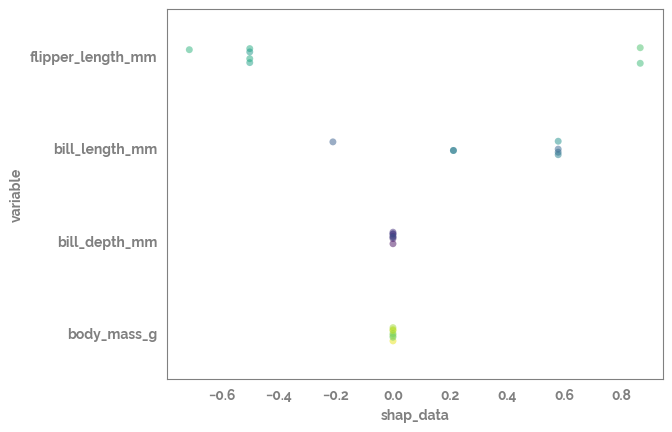

In [20]:
ax = sns.stripplot(data=shap_actual_df,
                  x="shap_data",
                  y="variable",
                  hue="actual_data",
                  order=shap_actual_df.groupby("variable").var()["shap_data"].sort_values(ascending=False).index.tolist(),
                  alpha=0.5,
                  palette="viridis")
_ = plt.legend([],[], frameon=False)

In [21]:
model = CatBoostRegressor(iterations=500,
                               depth=None,
                               learning_rate=1,
                               loss_function='RMSE',
                               verbose=False)

# train the model
_ = model.fit(X_train, y_train)

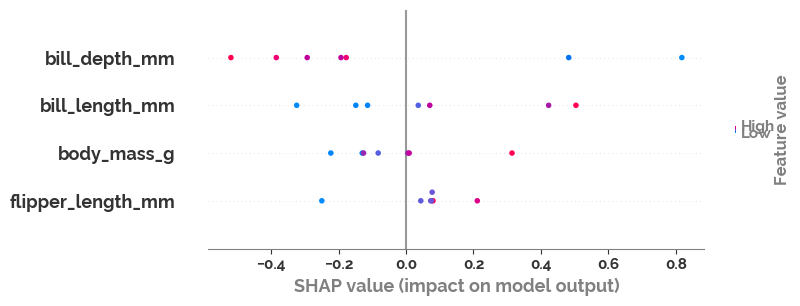

In [22]:
shap_values = model.get_feature_importance(Pool(X_test, label=y_test), type="ShapValues")

shap_values = shap_values[:,:-1]

_ = shap.summary_plot(shap_values, 
                                X_test.astype(int), 
                                feature_names=X_test.columns, 
                                max_display=X_test.shape[1],
                                show=True) 

In [23]:
shap_actual_df = pd.concat([pd.DataFrame(shap_values, columns=feature_list).melt(value_name="shap_data"),
pd.DataFrame(X_test.values, columns=feature_list).melt(value_name="actual_data").drop("variable", axis=1)], axis=1)
shap_actual_df.groupby("variable").apply(lambda d: d.sort_values(by="shap_data", ascending=False))

variable  shap_data  actual_data
variable                                                       
bill_depth_mm     10      bill_depth_mm   0.818202         14.4
                  7       bill_depth_mm   0.482597         15.0
                  8       bill_depth_mm  -0.177411         18.6
                  12      bill_depth_mm  -0.192946         17.8
                  9       bill_depth_mm  -0.293135         17.6
                  11      bill_depth_mm  -0.384892         18.3
                  13      bill_depth_mm  -0.519397         19.4
bill_length_mm    5      bill_length_mm   0.504091         58.0
                  1      bill_length_mm   0.422987         49.7
                  0      bill_length_mm   0.070388         50.7
                  3      bill_length_mm   0.036248         45.1
                  4      bill_length_mm  -0.114058         42.7
                  2      bill_length_mm  -0.149009         42.9
                  6      bill_length_mm  -0.324426         41.8
body_mass_g       21        body_mass_g   0.314360       5550.0
                  23        body_mass_g   0.009323       4700.0
                  24        body_mass_g   0.005250       4400.0
                  25        body_mass_g  -0.082579       4075.0
                  27        body_mass_g  -0.126033       4450.0
                  22        body_mass_g  -0.129898       3600.0
                  26        body_mass_g  -0.223122       3700.0
flipper_length_mm 17  flipper_length_mm   0.211454        210.0
                  14  flipper_length_mm   0.080028        223.0
                  18  flipper_length_mm   0.077535        196.0
                  20  flipper_length_mm   0.075776        198.0
                  16  flipper_length_mm   0.073180        196.0
                  15  flipper_length_mm   0.043788        195.0
                  19  flipper_length_mm  -0.249822        181.0